## Author:

Kamil Kaczor, 173367

Maks Operlejn, 171750

## Group:

Date: 13.06.21

## Subject: 

Uczenie maszynowe (summer 2020/2021)

 ## Import Packages

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
matplotlib.rcParams.update({'font.size': 18})
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout
from keras import optimizers
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10516261444678227724
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12073100166696133269
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


## Load dataset and choose classes

Classes chosen: 'dog', 'cat' and 'horse'.

In [16]:
# Load the CIFAR 10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Select three classes: 'dog', 'cat', 'horse'
indexes = [5, 3, 7]
no_of_classes = 3

idx_train = ((y_train == indexes[0]) | (y_train == indexes[1]) | (y_train == indexes[2])).reshape(x_train.shape[0])
idx_test = ((y_test == indexes[0]) | (y_test == indexes[1]) | (y_test == indexes[2])).reshape(x_test.shape[0])

x_train, y_train = x_train[idx_train], y_train[idx_train]
x_test, y_test = x_test[idx_test], y_test[idx_test]

print(x_train.shape)
print(y_train.shape)

(15000, 32, 32, 3)
(15000, 1)


## Preprocessing

In [17]:
x_train = x_train / 255.0
x_test = x_test / 255.0

mean = np.mean(x_train, axis = 0)
std = np.std(x_train, axis = 0)

test_mean = np.mean(x_test, axis = 0)
test_std = np.std(x_test, axis = 0)

x_train = (x_train - mean) / std
x_test = (x_test - test_mean) / test_std

y_test = np.array(list(map(int, y_test))).astype('uint8')
y_train = np.array(list(map(int, y_train))).astype('uint8')
print(y_test.shape, y_train.shape)

(3000,) (15000,)


In [18]:
classes = np.unique(y_train)
classes_num = len(classes)
print('Liczba klas: ', classes_num)
print('Klasy: ', classes)

Liczba klas:  3
Klasy:  [3 5 7]


Convert labels to 0, 1 and 2 to use to_categorical

In [19]:
y_train[y_train == 3] = 0
y_train[y_train == 5] = 1
y_train[y_train == 7] = 2
y_test[y_test == 3] = 0
y_test[y_test == 5] = 1
y_test[y_test == 7] = 2

Convert to float and change to categorical

In [20]:
dim_data = np.prod(x_train.shape[1:])
print(dim_data)
train_data = x_train.reshape(x_train.shape[0], dim_data)
test_data = x_test.reshape(x_test.shape[0], dim_data)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

3072


## Create MLP

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_8 (Dense)             (None, 3072)              9440256   
                                                                 
 dropout_4 (Dropout)         (None, 3072)              0         
                                                                 
 dense_9 (Dense)             (None, 3)                 9219      
                                                                 
Total params: 9,449,475
Trainable params: 9,449,475
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
446/446 [==============================] - 9s 20ms/step - loss: 3553.5569 - sparse_categorical_accuracy: 0.4771 - val_loss: 5737.0259 - val_sparse_categorical_accura

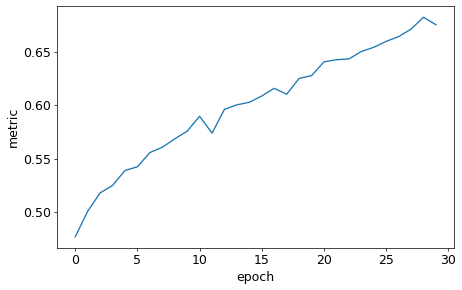

In [21]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(3072, activation = 'relu'),
    tf.keras.layers.Dropout(rate = 0.3),
    tf.keras.layers.Dense(no_of_classes, activation = 'softmax')           
  ])

keras_model.summary()

opt = tf.keras.optimizers.Adam(learning_rate = 0.05)

keras_model.compile(
    run_eagerly = True,
    optimizer = opt,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["sparse_categorical_accuracy"],
)

history = keras_model.fit(x_train, y_train, epochs = 30, batch_size = 32, validation_split = 0.05)
  
matplotlib.rcParams.update({'font.size': 14})
f = plt.figure(figsize = (8, 5), dpi = 64)
f1 = f.add_subplot(111)
f1.set_xlabel('epoch')
f1.set_ylabel('metric')
plt.plot(history.history["sparse_categorical_accuracy"])

plt.show()

## Model validation

In [23]:
y = keras_model.predict(x_test)
det = tf.cast((y + 0.5), tf.int32)
detections = tf.cast(det, tf.float32)

y_p = np.argmax(detections, axis = 1)

cm = tf.math.confusion_matrix(y_test, y_p) 
print("Confusion Matrix: ")
print(cm.numpy())

from sklearn.metrics import f1_score
f1_score(y_test, y_p, average = 'weighted')

Confusion Matrix: 
[[383 558  59]
 [235 683  82]
 [116 275 609]]


0.560226150025458